# PyWCPS

The problem: accessing WCPS from Python often means generating a string with the
query source code and then sending it to the server endpoint via REST or POST. For
non trivial queries, generating the string from Python code can be cumbersome
because of:

- Lack of tooling support (editor indentation, paren matching, etc...).
- The code is mostly generated with ad-hoc interpolation and concatenation of
  strings, which is weak in terms of abstraction and composability.
- WCPS code gets obscured since it is intertwined with Python code.

These problems can be greatly reduced by designing an Embedded Domain Specific
Language (EDSL). The EDSL design pattern aims to map the syntax of the embedded
language (here the WCPS language) into the syntax of a host language (here
Python). This allows for automatically reusing the abstraction capabilities
and tooling of the host language.

Below are a list of real examples from showing what we can achieve with this
approach. But before we start, better eval this for setup:

In [4]:
# Imports will be simplified as API stabilizes... by now let's eval this...
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
from dsl import *
from ast_rewrite import wcps
from wcps_client import WCPSClient, emit_fun

eo = WCPSClient('http://earthserver.pml.ac.uk/rasdaman/ows/wcps')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The following examples are from the Domain Examples Notebook of GeoPython 2017 (mine is at: https://jupyter.eofrom.space/user/jarnaldich/notebooks/jupyter_notebooks/geopython_workshop_2017/Domain_examples.ipynb)

This query:
```
for  d in (CCI_V2_monthly_chlor_a_rmsd)
return 
encode((float)

 count(d[ ansi("2010-01-31T23:59:00")] < 0.2 )
, "csv"

)
```
Is equivalent to the following Python snippet:

In [8]:
@wcps
def test_cloro():
    return For(c="CCI_V2_monthly_chlor_a_rmsd")[
         encode(cast('float',
                    count(c[ansi("2010-01-31T23:59:00")] < 0.201)),
               "csv")]

float(eo.get_str(test_cloro))

13929.0

The mechanics of the above should be fairly obvious. The user needs to define a function and decorate it with `wcps`. The decorator performs some magic so that WCPS code can be obtained from the function definition. The generated code can always be inspected, by the way:

In [9]:
emit_fun(test_cloro)

'for c in (CCI_V2_monthly_chlor_a_rmsd) return encode((float) count((c[ansi("2010-01-31T23:59:00")] < 0.201)), "csv")'

Another simple example, from the same notebook:

```
for c in ( CCI_V2_release_chlor_a ), d in (CCI_V2_monthly_chlor_a_rmsd)
return 
encode((float)
 avg(
 c[Long(0:10), Lat(45:55), ansi("2010-01-31T23:59:00")] *
  (d[Long(0:10), Lat(45:55), ansi("2010-01-31T23:59:00")] < 0.1 )
 ), "csv"

)
```
Translates to:

In [4]:
@wcps
def test_cloro2():
    return For(c="CCI_V2_release_chlor_a",
               d="CCI_V2_monthly_chlor_a_rmsd")[
        encode(
          cast('float',
             avg(c[axis('Long',0,10),
                   axis('Lat', 45,55),
                   axis('ansi', '2010-01-31T23:59:00')] *
                 (d[axis('Long',0,10),
                    axis('Lat', 45,55),
                    axis('ansi', '2010-01-31T23:59:00')] < 0.45))
        ), "csv")]


float(eo.get_str(test_cloro2))

0.286275

That would be the most direct translation, but we can begin to see the advantadges of a EDSL when we realize that we can use plain Python to factor away the repetitive stuff. Getting away with repetitions increases readability and shows better what the intent of the query was.

We can also easly parameterize queries as normal Python functions, and integrate them into other Python code...

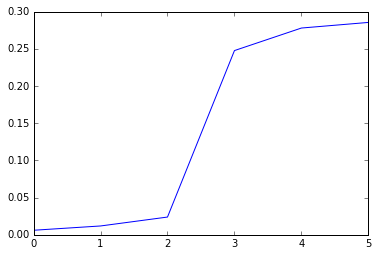

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

# We can parameterize the threshold
@wcps
def test_cloro2(threshold):
    # We can define the slice here...
    slice = (axis('Long',0,10),
             axis('Lat', 45,55),
             axis('ansi', '2010-01-31T23:59:00'))
    
    # And the query looks like...
    return For(c="CCI_V2_release_chlor_a",
               d="CCI_V2_monthly_chlor_a_rmsd")[
        encode(
          cast('float',
             avg(c[slice] * (d[slice] < threshold))
        ), "csv")]

plt.plot([float(eo.get_str(test_cloro2, float(x)/100)) for x in range(35,41)])

Finally, we can write this crime of a query:
```
for a in (CCI_V2_monthly_chlor_a) return encode (switch case 0.05 > a[Lat(30:70),Long(-30:10),ansi("2009-09-30T23:59:00Z")] return {red: 255; green: 255; blue: 255; alpha: 0} case 0.1 > a[Lat(30:70),Long(-30:10),ansi("2009-09-30T23:59:00Z")]  return {red: 0; green: 255; blue: 255; alpha: 255} case 0.2 > a[Lat(30:70),Long(-30:10),ansi("2009-09-30T23:59:00Z")]  return {red: 0; green: 128; blue: 255; alpha: 255} case 0.5 > a[Lat(30:70),Long(-30:10),ansi("2009-09-30T23:59:00Z")]  return {red: 0; green: 0; blue: 255; alpha: 255} case 1.5 > a[Lat(30:70),Long(-30:10),ansi("2009-09-30T23:59:00Z")]  return {red: 218; green: 0; blue: 255; alpha: 255} case 3.0 > a[Lat(30:70),Long(-30:10),ansi("2009-09-30T23:59:00Z")]  return {red: 255; green: 0; blue: 255; alpha: 255} case 4.5 > a[Lat(30:70),Long(-30:10),ansi("2009-09-30T23:59:00Z")]  return {red: 255; green: 164; blue: 0; alpha: 255} case 6.2 > a[Lat(30:70),Long(-30:10),ansi("2009-09-30T23:59:00Z")]  return {red: 255; green: 250; blue: 0; alpha: 255} case 20 > a[Lat(30:70),Long(-30:10),ansi("2009-09-30T23:59:00Z")]  return {red: 255; green: 0; blue: 0; alpha: 255} default return {red: 255; green: 255; blue:255; alpha: 0} ,"png")
```
as:

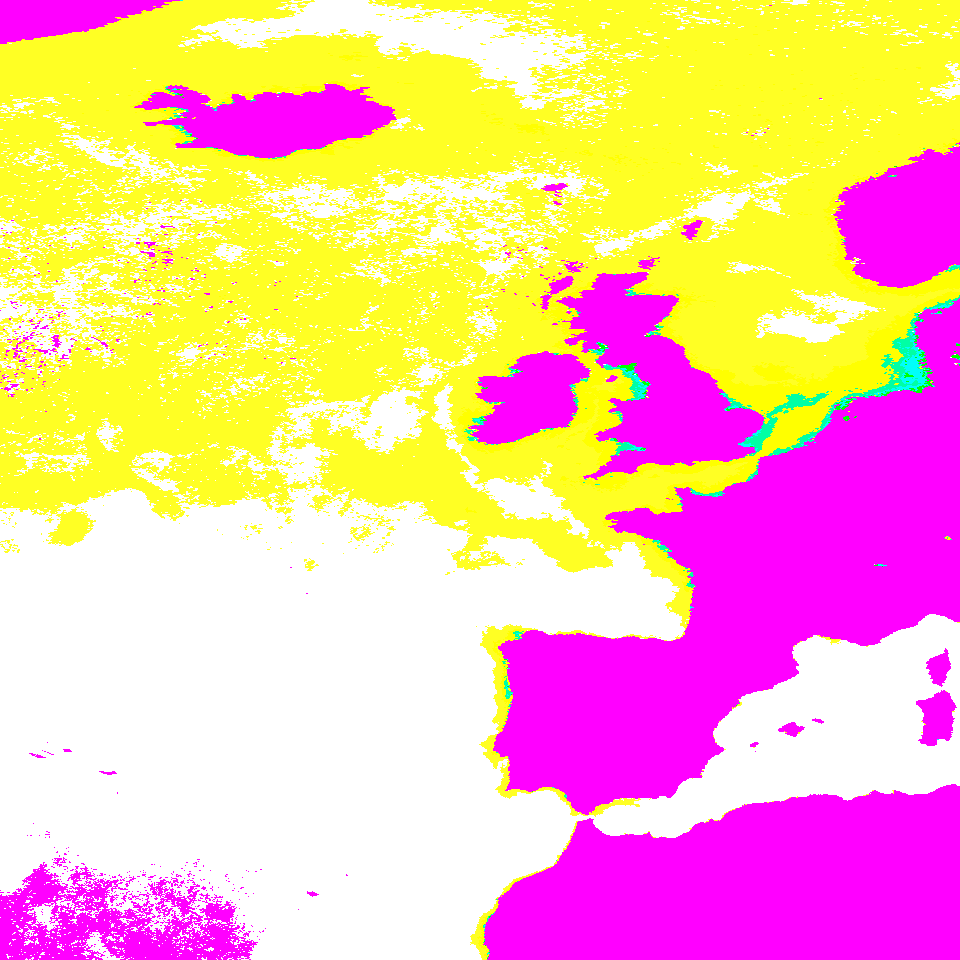

In [28]:
@wcps
def test_colortable():

    def less_than(cov, x):
        return  cov[axis('Lat', 30,70),
                  axis('Long', -30,10),
                  axis('ansi', "2009-09-30T23:59:00Z")] < x

    def rgba(r,g,b,a):
        return struct(red=r, green=g, blue=b, alpha=a)

    return For(a="CCI_V2_monthly_chlor_a")[
            encode(
                switch(
                    case(less_than(a, 0.05), rgba(255, 255, 255,   0)),
                    case(less_than(a,  0.1), rgba(  0, 255, 255, 255)),
                    case(less_than(a,  0.2), rgba(  0, 128, 255, 255)),
                    case(less_than(a,  0.5), rgba(  0,   0, 255, 255)),
                    case(less_than(a,  1.5), rgba(218,   0, 255, 255)),
                    case(less_than(a,  3.0), rgba(255,   0, 255, 255)),
                    case(less_than(a,  4.5), rgba(255, 164,   0, 255)),
                    case(less_than(a,  6.2), rgba(255, 250,   0, 255)),
                    case(less_than(a,   20), rgba(255,   0,   0, 255)),
                    default(rgba(255, 255, 255,  0))), "png")]

eo.ipython_image(test_colortable)

which looks kinda cute. Notice that the helper functions do not need to be inner functions. They could just as well be outside for reuse, if needed. For example, it would be entirely possible to write a function that automatically generates the switch statement for a colorscale like the above from a list of value cuts, which would make the above function even shorter.

Before you ask, I got the coverage constructor, too... I called it "New"

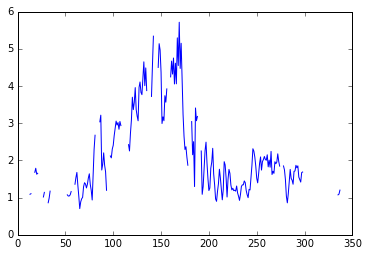

In [6]:
@wcps
def test_coverage_constructor():
    l = 100000
    def roi(cov, time):
        return cov[axis('Long', -50, -40),
                   axis('Lat', 45,55),
                   axis('ansi', time, crs="CRS:1")]

    def term(cov, time):
        return (add((roi(cov, time) < l) * roi(cov, time))
                /
                count(roi(cov, time) < l))

    return For(c="CCI_V2_release_daily_chlor_a")[
            encode(cast('float',
                        New('histogram',
                            px=axis('x', 0, 0),
                            py=axis('y', 0, 0),
                            pt=axis('t', 0, 360))[
                                term(c, pt) #+ term(c, pt+1) + term(c, pt+2)
                            ]), "csv")]


res_txt = eo.get_str(test_coverage_constructor)
plt.plot([float(x) for x in res_txt[2:-2].split(",")])

Now, if you buy it...

# The Plan

  Writing a EDSL for a language that I do not know that much can be a bit risky,
  so I prefer to start small. What I am more interested now is in getting the
  structure right before adding a whole lot of functions. 
  
  For example, I have just implemented the functions and operators that I needed
  for the queries above (avg, count, +, *). I have left the others out
  intentionally because I first need to make sure the structure is solid.
  
  That is where I would like to get feedback/help:
  
  - Can you think of a language construct I have left out? I'd be especially
    interested in any query that has essentialy a different structure than the
    ones I have already implemented... BTW
    
  - I know I have left out the literal coverage constructor and the condense expression, do you have any examples I can use to test the thing?
    
  - I have seen in the documentation that one can write for example a
    convolution. Any complete example on that?
    
  - Can we have sub-coverages like (for c in (coverage Potato over ...)) (I mean, using a coverage constructor where a Coverage ID would be normally expected) any examples on that?
  
  - Any example of planetary science queries?
  
  - Any suggestions on the syntax? Any suggestions on how to proceed? Eg. I can try and start translating into this syntax whatever code you want... let's make this a challenge?
  
  Bear in mind that there errors and quirks may appear (eg. if operator precedence in Python is different than WPCPS)... better double-check the results at the beginning.

  If you are interested in *how* I am doing it now, keep reading... Full documentation should be ready as API gets more stable.

If this goes on, in the future some cool things are technically possible:

- Checking for Type Errors.
- Pretty-printing of the generated code for inspection.
- Better error reporting. By now we rely on the error reporting of the server.
- Checking for correctness for a particular server (that coverage names exist, that dimension labels are OK, etc...)

# Design Principles

  The goal  should be to make it possible to express WCPS Language queries as
  Python constructs. All WCPS functionality should be available.
  
  When designing a DSL, some compromises have to be made. One can imagine trying
  to make the surface syntax as close to the embedded language (WCPS) as possible,
  at the expense of forcing the syntax of the host language (being un-Pythonic),
  or to ignore the syntax of the host language whatsoever and just provide a
  library for the host, at the expense of making this library counter intuitive for
  the users of the embedded language. 
  
  Designing a EDSL often involves a non-negligible amount of magic (on the fly syntax
  manipulation, run-time code generation, introspection, etc...). These tools,
  when not used with care, can lead to unexpected and uninutitive behaviours for
  the programmer.
  
  This project will try to find a sweet spot where the Python code can still be
  understandable as WSDL without forcing Python too much. To do so we will try
  to follow one basic design principle: the EDSL will be an *expression language*.
  
  Remember that expressions in Python (and other languages) are any constructs
  that have a value, can be assigned to a variable, passed to a function, etc...
  Contrast this with statements, that are there for side-effects.
  
  Examples of expressions: `1+1`, `sin(x)`. Examples of non expressions `a=1+1`,
  `if`s, `for`s, `def`s...
  
  I think expressions are especially suitable in this case because WCPS language is
  essentially an expression language (eg. queries are essentially more or less
  big expresions that return a result).
  
  Expressions have the nice property that they are _composable_: bigger
  expressions can be built from the combination of smaller ones, which is good
  for reuse and abstraction.
  
  Furthermore, expressions map very naturally into Python syntax. The only
  exception are the _binding_ forms in WSCPS, that is those that "declare"
  variable, namely the `for` (that bind coverage variables) and the
  coverage constructors (that declare index variables). The only binding forms in Python are function and class declarations, which are not expressions, so a little AST manipulation is needed to bridge that
  gap. Hopefully this will not result in any quirks when writing the code if the
  coder assumes the basic design principle: that the whole EDSL is made of
  expressions.
  
  For binding forms, I came up with the following syntax:
  
  ``` For(var=value ...)[ <body where var can be used> ]  ```
  
  For Python, this is just a call followed by an indexing operator, which are expressions... The decorator will walk the AST of the function code in search for those expressions, and will transform them into automatically generated python functions, but hopefully you do not need to think about that. Just bear in mind that the vars are only available *between* the square brackets. This mirrors WCSPL behaviour, but is un-Pythonic, since in Python variables have function (or class) scope (eg any variable used in a for loop is avalable throughout the function, not just inside the for loop).
  
This function illustrates what I mean. Both `i` and `z` ara available inside the whole function:  

In [14]:
def scope_rules_in_python_are_demented():
    for i in range(10):
        z = 2
        pass
    print i, z
    
scope_rules_in_python_are_demented()

9 2


  
# A sketch of the implementation

  90% of EDSL are just python functions (defined in `dsl.py`) that, when
  composed, build an AST (Abstract Syntax Tree) from the ground up. The root
  node of this AST can later
  be asked to emit the string that represents the WCPS query. The nodes of this
  AST can be seen in the file `ast_nodes.py` and are just Python classes. Note
  that this AST is different from the one needed to parse the WCPS language,
  since we are just interested in code emission, which is easier.
  
  The only piece of magic are the binding forms `For` and `New`, which are
  syntactically expressions but have to be transformed via source inspection and AST walking
  into Python binding forms (functions under the hood). If done right, this
  should be transparent to the coder.
  
  The code can be found in my github: https://github.com/jarnaldich/pywcps
  
 